# Inversion of a sphere based on gravity response
# ( Transfer to TensorFlow 2.0)

This is a simple example for the probabilistic inversion of a classical geophysical example: the inversion of a sphere in the subsurface with a different density to the environment based on observed gravity data.

We start with the simplest possible case of only one observation (directly above the sphere) and only depth as an uncertain variable and then make the model progressively more complex.

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

np.random.seed(111)
# tf.set_random_seed(111)


We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:

- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [2]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


## Geometric model

We consider here a sphere in the subsurface with a different density. 

spherical point mass

In [3]:
#True model

sphere_center_true = 300. #m 
density_difference_true = 500. # kg/m^3: density diffrence to surrounding domain
sphere_radius_true = 100. #m

truevalue_list = [sphere_center_true,density_difference_true,sphere_radius_true]
x_domain=np.linspace(-1000,1000,101) #m

In [4]:
x_obs = np.linspace(-250., 250., 11.)
grav_all = grav_analytical(x_domain, sphere_center_true, sphere_radius_true, density_difference_true)
grav_obs_array = grav_analytical(x_obs, sphere_center_true, sphere_radius_true, density_difference_true)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_withnoise = grav_obs_array +noise

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [5]:
grav_obs_array_withnoise

array([0.05903379, 0.09325413, 0.12603046, 0.12897358, 0.1410927 ,
       0.15062356, 0.14837635, 0.12898567, 0.10370969, 0.07757154,
       0.07276111])

Calculate the variance of the noise, put the variance in an noise tensor

In [6]:
noise_variance = np.std(noise)**2

noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)
eye = tf.eye(x_obs.shape[0])
noise_tensor = tf.multiply(noise_1,eye)

Text(0, 0.5, 'Y [m]')

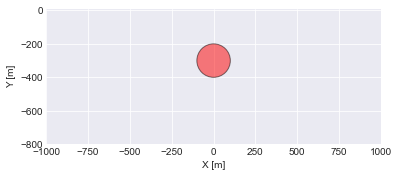

In [7]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center_true), sphere_radius_true, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")


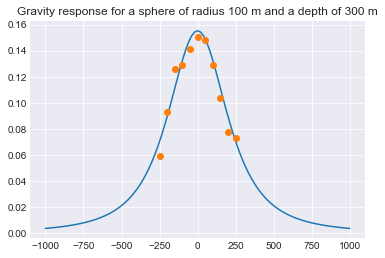

In [8]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_withnoise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");

### Algorithm Flowing hIPPYlib MCMC http://g2s3.com/labs/notebooks/SubsurfaceBayesian.html

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Define the Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [9]:
# sphere_center, density_difference, sphere_radius

mu_prior = [280., 480., 80.]


cov = [[ 100,  0.,  0.],
        [ 0.,  100, 0.],
        [ 0., 0.,  100]]


In [10]:
xvals =[]
norm_list =[]

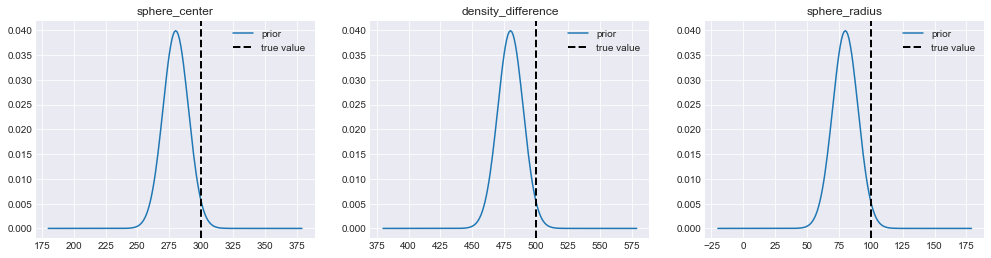

In [11]:
for i in range(3):
    xvals.append(np.arange(mu_prior[i]-100,mu_prior[i]+100))
    norm_list.append(norm.pdf(xvals[i],mu_prior[i],np.sqrt(cov[i][i])))
    
np.shape(xvals)

name_list = ["sphere_center", "density_difference", "sphere_radius"]

fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
fig.set_size_inches(17, 4)


for i in range(3):
    
    axes[i].plot(xvals[i], norm_list[i],label="prior")
    axes[i].title.set_text(name_list[i])
    axes[i].axvline(truevalue_list[i], label="true value", color='k', 
            linestyle='--', linewidth=2)
    axes[i].legend();

    

Define the Likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [12]:
mu_prior = tf.convert_to_tensor(mu_prior)
cov = tf.convert_to_tensor(cov)


In [13]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.
@tf.function
def grav_analytical_tf(x, mu, cov,sess):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    return gravity



### Gradient decent to find MAP (?)

In [14]:
## function compute G^T C^-1 G

@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1 = 
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

term 2 =
\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [15]:
#     print(sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)))

## initial guess
mu = tf.Variable([200., 400., 50.])

In [16]:
@tf.function
def grav_analytical_tf_det(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    
    G=tf.constant(6.67e-11,dtype = tf.float32)
    sphere_center = mu[0]
    density_difference = mu[1]
    sphere_radius = mu[2]
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    return gravity

In [17]:
grav_obs_array_withnoise = tf.convert_to_tensor(grav_obs_array_withnoise,dtype=tf.float32)
x_obs = tf.convert_to_tensor(x_obs,dtype=tf.float32)

In [18]:
cost = []

def loss(mu):
    grav = grav_analytical_tf_det(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    return tf.add(term_1,term_2)


def loss_minimize():
    grav = grav_analytical_tf_det(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    return tf.add(term_1,term_2)

opt = tf.keras.optimizers.SGD(learning_rate=0.1)

step = 5000

for i in range(step):
    
    opt.minimize(loss_minimize, var_list=mu)
    print (loss(mu).numpy(), mu.numpy())
    cost.append(loss(mu).numpy())

    
MAP = mu

[[895.53094]] [199.77829  400.1845    52.538498]
[[820.0576]] [199.52261 400.38092  55.23003]
[[736.90784]] [199.23236  400.58957   58.060658]
[[647.52936]] [198.90913  400.81012   61.003853]
[[554.5952]] [198.55779 401.04123  64.01716]
[[462.08276]] [198.18747 401.28018  67.03993]
[[374.9473]] [197.81229 401.52267  69.99399]
[[298.2545]] [197.45091 401.76297  72.78905]
[[235.90857]] [197.12459 401.99448  75.33415]
[[189.50908]] [196.85344 402.21085  77.55362]
[[158.01324]] [196.6522  402.40732  79.40244]
[[138.4465]] [196.52716 402.5817   80.87449]
[[127.18802]] [196.47565 402.7345   81.99947]
[[121.05805]] [196.48836 402.86832  82.83071]
[[117.793686]] [196.55278  402.98672   83.430084]
[[116.01042]] [196.65628 403.09338  83.85621]
[[114.94975]] [196.78792  403.1915    84.158104]
[[114.227875]] [196.93907 403.28357  84.37351]
[[113.66106]] [197.1034  403.3715   84.52992]
[[113.16457]] [197.27638 403.45657  84.64664]
[[112.700424]] [197.45496 403.53976  84.73687]
[[112.251755]] [197.6

[[59.600285]] [225.27095 417.2216   90.16703]
[[59.42723]] [225.3837  417.28653  90.1869 ]
[[59.25491]] [225.49617 417.3514   90.2067 ]
[[59.083313]] [225.60837 417.41623  90.22645]
[[58.91244]] [225.72029 417.48096  90.24613]
[[58.74227]] [225.83194 417.54562  90.26575]
[[58.57284]] [225.94333 417.61023  90.28531]
[[58.404087]] [226.05444 417.67477  90.3048 ]
[[58.23605]] [226.16528 417.73926  90.32424]
[[58.06873]] [226.27586 417.80365  90.34362]
[[57.902092]] [226.38618 417.86798  90.36294]
[[57.736153]] [226.49623  417.93225   90.382195]
[[57.570866]] [226.60602 417.99646  90.40139]
[[57.40628]] [226.71555  418.0606    90.420525]
[[57.2424]] [226.8248  418.12466  90.4396 ]
[[57.079205]] [226.93379 418.18866  90.45861]
[[56.916683]] [227.04253 418.2526   90.47757]
[[56.7548]] [227.151   418.31647  90.49647]
[[56.593597]] [227.25922 418.38028  90.51531]
[[56.433075]] [227.36717  418.444     90.534096]
[[56.27321]] [227.47487 418.50766  90.55282]
[[56.114002]] [227.58232 418.57126  90

[[34.098793]] [244.71881 429.95084  93.37529]
[[34.022774]] [244.7882  430.00262  93.38591]
[[33.947002]] [244.85744 430.05435  93.3965 ]
[[33.871513]] [244.92654 430.10602  93.40706]
[[33.796253]] [244.9955   430.15765   93.417595]
[[33.721237]] [245.06432 430.20923  93.4281 ]
[[33.646515]] [245.133    430.26074   93.438576]
[[33.572006]] [245.20154 430.31223  93.44902]
[[33.497757]] [245.26994 430.36365  93.45944]
[[33.42376]] [245.3382  430.415    93.46984]
[[33.350033]] [245.40631 430.4663   93.48021]
[[33.276535]] [245.47429 430.51758  93.49055]
[[33.203285]] [245.54213 430.5688   93.50086]
[[33.130272]] [245.60983 430.61993  93.51115]
[[33.057537]] [245.6774  430.67102  93.5214 ]
[[32.985016]] [245.74483 430.72208  93.53163]
[[32.912746]] [245.81212 430.77307  93.54184]
[[32.84073]] [245.87927 430.824    93.55202]
[[32.768944]] [245.94629 430.8749   93.56217]
[[32.69741]] [246.01317  430.92575   93.572296]
[[32.62609]] [246.07991 430.97653  93.5824 ]
[[32.555027]] [246.14653 431.

[[22.156662]] [257.06335 440.1177   95.15799]
[[22.118603]] [257.1087   440.15912   95.164116]
[[22.080656]] [257.15396 440.2005   95.17022]
[[22.042833]] [257.19913  440.24182   95.176315]
[[22.005123]] [257.2442   440.2831    95.182396]
[[21.967499]] [257.2892  440.32437  95.18845]
[[21.930014]] [257.33414 440.36557  95.1945 ]
[[21.89263]] [257.37897 440.40674  95.20054]
[[21.855354]] [257.42374 440.44785  95.20656]
[[21.818188]] [257.4684  440.48892  95.21256]
[[21.781132]] [257.513   440.52997  95.21855]
[[21.744196]] [257.5575   440.57095   95.224525]
[[21.707357]] [257.60193 440.6119   95.23049]
[[21.670626]] [257.64627  440.65283   95.236435]
[[21.634005]] [257.69052 440.6937   95.24237]
[[21.597488]] [257.7347  440.73453  95.24829]
[[21.56108]] [257.7788   440.77533   95.254196]
[[21.524792]] [257.8228   440.81607   95.260086]
[[21.488588]] [257.86676 440.85678  95.26596]
[[21.452501]] [257.9106  440.89746  95.27182]
[[21.41652]] [257.95438 440.93808  95.27767]
[[21.380642]] [2

[[15.963901]] [265.2641  448.25455  96.20452]
[[15.943407]] [265.2947   448.28772   96.208176]
[[15.922977]] [265.32526 448.32086  96.21182]
[[15.902602]] [265.35574  448.35397   96.215454]
[[15.882284]] [265.3862  448.38702  96.21908]
[[15.862022]] [265.4166   448.42004   96.222694]
[[15.841816]] [265.44693 448.45303  96.22631]
[[15.821669]] [265.4772  448.486    96.22991]
[[15.801563]] [265.50745  448.51892   96.233505]
[[15.781515]] [265.53763 448.55182  96.23709]
[[15.761524]] [265.56775 448.5847   96.24067]
[[15.741588]] [265.5978  448.61752  96.24424]
[[15.721706]] [265.62784 448.65033  96.2478 ]
[[15.701872]] [265.6578  448.6831   96.25136]
[[15.682096]] [265.6877  448.71585  96.2549 ]
[[15.6623745]] [265.7176  448.74854  96.25843]
[[15.642702]] [265.7474  448.7812   96.26196]
[[15.623095]] [265.77716 448.8138   96.26549]
[[15.603527]] [265.8069 448.8464  96.269 ]
[[15.584009]] [265.83655 448.87897  96.2725 ]
[[15.5645485]] [265.86615 448.9115   96.27599]
[[15.545152]] [265.8957

[[12.544903]] [270.87473 454.79932  96.8353 ]
[[12.53339]] [270.89575  454.82587   96.837494]
[[12.521914]] [270.91675 454.8524   96.83968]
[[12.510456]] [270.9377  454.87888  96.84187]
[[12.499037]] [270.95862  454.90533   96.844055]
[[12.487638]] [270.9795  454.9318   96.84623]
[[12.476278]] [271.00034  454.95822   96.848404]
[[12.464935]] [271.02115 454.98462  96.85057]
[[12.453629]] [271.04193 455.011    96.85273]
[[12.442348]] [271.06268 455.03732  96.85489]
[[12.431099]] [271.0834  455.06363  96.85704]
[[12.419881]] [271.10406 455.0899   96.85919]
[[12.4086895]] [271.1247   455.11615   96.861336]
[[12.397523]] [271.1453  455.1424   96.86347]
[[12.386383]] [271.16586 455.1686   96.86561]
[[12.375273]] [271.1864  455.1948   96.86774]
[[12.364193]] [271.2069  455.22095  96.86986]
[[12.353136]] [271.2274  455.24707  96.87198]
[[12.342111]] [271.24783 455.27316  96.87409]
[[12.331119]] [271.26822  455.29922   96.876205]
[[12.320148]] [271.28857 455.3253   96.87831]
[[12.309202]] [271.

[[10.59468]] [274.7529   460.04013   97.214226]
[[10.588013]] [274.76752 460.0614   97.21554]
[[10.581358]] [274.7821  460.08264  97.21685]
[[10.574719]] [274.7967   460.10385   97.218155]
[[10.56809]] [274.81125 460.12506  97.21946]
[[10.561478]] [274.82578  460.14624   97.220764]
[[10.554892]] [274.84027 460.1674   97.22206]
[[10.548308]] [274.85474 460.18854  97.22336]
[[10.541751]] [274.8692  460.20966  97.22465]
[[10.535208]] [274.88364 460.23074  97.22594]
[[10.528677]] [274.89804 460.25183  97.22723]
[[10.52216]] [274.9124  460.2729   97.22851]
[[10.515665]] [274.9268  460.2939   97.22978]
[[10.509182]] [274.94113  460.3149    97.231064]
[[10.502714]] [274.95544 460.3359   97.23234]
[[10.496265]] [274.96973 460.35687  97.23361]
[[10.489826]] [274.984   460.3778   97.23488]
[[10.483409]] [274.99826  460.39874   97.236145]
[[10.477003]] [275.01248  460.41965   97.237404]
[[10.470617]] [275.02667 460.44052  97.23866]
[[10.464243]] [275.04083 460.4614   97.23992]
[[10.457883]] [275.

[[9.4518585]] [277.46094 464.23813  97.43849]
[[9.447903]] [277.4712   464.25516   97.439255]
[[9.443954]] [277.4814  464.2722   97.44002]
[[9.440018]] [277.49164 464.28918  97.44078]
[[9.436088]] [277.50183  464.30618   97.441536]
[[9.432167]] [277.51202 464.32315  97.44229]
[[9.428261]] [277.5222  464.3401   97.44305]
[[9.424354]] [277.53235 464.35703  97.4438 ]
[[9.420465]] [277.54248 464.37393  97.44456]
[[9.416583]] [277.5526   464.39084   97.445305]
[[9.412709]] [277.5627  464.4077   97.44605]
[[9.408841]] [277.5728 464.4246  97.4468]
[[9.4049835]] [277.5829  464.44144  97.44755]
[[9.401136]] [277.59293 464.45828  97.44829]
[[9.397297]] [277.60297 464.4751   97.44903]
[[9.393471]] [277.61298 464.49188  97.44977]
[[9.38965]] [277.623   464.50867  97.45051]
[[9.385844]] [277.63297 464.52542  97.45124]
[[9.382034]] [277.64294 464.54218  97.45197]
[[9.3782425]] [277.6529   464.5589    97.452705]
[[9.374456]] [277.66284 464.57562  97.45343]
[[9.370684]] [277.67276  464.59232   97.4541

[[8.768776]] [279.3648   467.60147   97.566505]
[[8.766391]] [279.37204 467.6151   97.56693]
[[8.764013]] [279.37924 467.62875  97.56735]
[[8.761636]] [279.38644 467.64236  97.56777]
[[8.759264]] [279.39365 467.65598  97.56819]
[[8.756905]] [279.40082 467.66956  97.56861]
[[8.754549]] [279.408   467.68314  97.56903]
[[8.752192]] [279.41516 467.69672  97.56945]
[[8.749842]] [279.4223  467.71027  97.56986]
[[8.747499]] [279.42944  467.72382   97.570274]
[[8.745165]] [279.43655 467.73734  97.57069]
[[8.742832]] [279.44366 467.75085  97.5711 ]
[[8.740506]] [279.45078 467.76434  97.57151]
[[8.738182]] [279.45786 467.77783  97.57192]
[[8.735868]] [279.46494 467.7913   97.57233]
[[8.733554]] [279.47202 467.80475  97.57273]
[[8.731245]] [279.47906  467.8182    97.573135]
[[8.728949]] [279.4861  467.83163  97.57354]
[[8.726652]] [279.49313  467.84506   97.573944]
[[8.724365]] [279.50015 467.85846  97.57435]
[[8.7220745]] [279.50717  467.87186   97.574745]
[[8.719798]] [279.51416 467.88522  97.5

[[8.354312]] [280.70932 470.29648  97.63448]
[[8.352856]] [280.71445 470.3074   97.6347 ]
[[8.351396]] [280.71954 470.31833  97.63491]
[[8.349948]] [280.72464 470.32925  97.63512]
[[8.348502]] [280.72974 470.34015  97.63532]
[[8.347057]] [280.7348  470.35104  97.63553]
[[8.3456135]] [280.73987  470.36194   97.635735]
[[8.344176]] [280.74493 470.3728   97.63594]
[[8.342741]] [280.75    470.38367  97.63615]
[[8.34131]] [280.75504 470.39453  97.63635]
[[8.33988]] [280.76007 470.40536  97.63656]
[[8.338453]] [280.7651   470.4162    97.636765]
[[8.33703]] [280.77014 470.427    97.63696]
[[8.335614]] [280.77515 470.4378   97.63716]
[[8.334197]] [280.78015 470.4486   97.63736]
[[8.332787]] [280.78516 470.45938  97.63756]
[[8.331377]] [280.79016 470.47015  97.63776]
[[8.329968]] [280.79514  470.48093   97.637955]
[[8.328565]] [280.8001  470.49167  97.63815]
[[8.327164]] [280.80508 470.5024   97.63835]
[[8.325762]] [280.81006 470.51315  97.63855]
[[8.324373]] [280.815   470.52386  97.63875]
[[8

[[8.133582]] [281.5275  472.13464  97.66216]
[[8.132611]] [281.53134 472.14374  97.66226]
[[8.131638]] [281.5352  472.15283  97.66236]
[[8.130669]] [281.539   472.1619   97.66246]
[[8.129703]] [281.54282 472.17096  97.66256]
[[8.128738]] [281.54663 472.18002  97.66265]
[[8.127777]] [281.55045 472.18906  97.66274]
[[8.126816]] [281.55426 472.1981   97.66284]
[[8.125857]] [281.55804 472.20712  97.66294]
[[8.124906]] [281.56183 472.21613  97.66303]
[[8.123947]] [281.5656   472.22513   97.663124]
[[8.122995]] [281.5694   472.23413   97.663216]
[[8.122045]] [281.57318 472.24313  97.66331]
[[8.121096]] [281.57693 472.2521   97.6634 ]
[[8.1201515]] [281.5807  472.26108  97.66349]
[[8.119206]] [281.58444 472.27005  97.66358]
[[8.118263]] [281.5882  472.279    97.66367]
[[8.117329]] [281.59195  472.28793   97.663765]
[[8.11639]] [281.59567 472.29688  97.66386]
[[8.115452]] [281.5994  472.30582  97.66395]
[[8.114517]] [281.60312 472.31473  97.66403]
[[8.113587]] [281.60684  472.32364   97.664116

[[7.9637456]] [282.24014 473.92233  97.67352]
[[7.9631405]] [282.24286 473.92963  97.67354]
[[7.9625316]] [282.24557 473.93692  97.67355]
[[7.9619284]] [282.2483  473.94418  97.67356]
[[7.961327]] [282.251   473.95145  97.67358]
[[7.9607286]] [282.25372 473.9587   97.67359]
[[7.960127]] [282.25644 473.96597  97.6736 ]
[[7.959528]] [282.25916 473.97324  97.67361]
[[7.958933]] [282.26187 473.98047  97.67362]
[[7.9583373]] [282.26456 473.9877   97.67364]
[[7.9577465]] [282.26724  473.99493   97.673645]
[[7.9571443]] [282.26993 474.00217  97.67365]
[[7.9565587]] [282.2726  474.00937  97.67366]
[[7.955965]] [282.2753  474.01657  97.67367]
[[7.9553757]] [282.27798 474.02377  97.67368]
[[7.9547873]] [282.28067 474.03098  97.67369]
[[7.9541993]] [282.28333 474.03815  97.6737 ]
[[7.953618]] [282.28598  474.04532   97.673706]
[[7.9530354]] [282.28864 474.0525   97.67371]
[[7.952448]] [282.2913  474.05966  97.67372]
[[7.951866]] [282.29395 474.0668   97.67373]
[[7.9512854]] [282.2966  474.07394  

[[7.856858]] [282.75162 475.36826  97.67061]
[[7.856479]] [282.75357 475.37408  97.67058]
[[7.856102]] [282.7555  475.3799   97.67055]
[[7.855726]] [282.75742 475.38574  97.67051]
[[7.855352]] [282.75934 475.39157  97.67047]
[[7.8549733]] [282.76126 475.3974   97.67043]
[[7.8546]] [282.76318  475.4032    97.670395]
[[7.8542266]] [282.7651  475.409    97.67036]
[[7.8538556]] [282.76703 475.4148   97.67032]
[[7.8534837]] [282.76895 475.4206   97.67029]
[[7.8531094]] [282.77087 475.4264   97.67025]
[[7.8527412]] [282.7728  475.43216  97.67021]
[[7.85237]] [282.7747  475.43793  97.67018]
[[7.852004]] [282.77658 475.4437   97.67014]
[[7.8516326]] [282.77847  475.44946   97.670105]
[[7.851266]] [282.78036 475.45523  97.67007]
[[7.850903]] [282.78226 475.46097  97.67003]
[[7.8505354]] [282.78415 475.4667   97.66999]
[[7.850169]] [282.78604 475.47244  97.66995]
[[7.8498077]] [282.78793  475.47818   97.669914]
[[7.8494387]] [282.78983  475.48392   97.669876]
[[7.8490777]] [282.79172 475.48965  

[[7.7911353]] [283.10834  476.5026    97.660065]
[[7.7908955]] [283.10974 476.5073   97.66   ]
[[7.790651]] [283.11115 476.512    97.65994]
[[7.790412]] [283.11252 476.5167   97.65989]
[[7.7901745]] [283.1139  476.5214   97.65983]
[[7.789937]] [283.11526 476.52606  97.65977]
[[7.7897034]] [283.11664  476.53073   97.659706]
[[7.7894645]] [283.118    476.5354    97.659645]
[[7.789228]] [283.1194   476.54007   97.659584]
[[7.7889895]] [283.12076 476.54474  97.65952]
[[7.7887564]] [283.12213 476.5494   97.65946]
[[7.7885213]] [283.1235  476.55405  97.6594 ]
[[7.7882843]] [283.12488 476.5587   97.65934]
[[7.7880507]] [283.12625 476.56332  97.65928]
[[7.787819]] [283.12762 476.56796  97.65922]
[[7.787583]] [283.129   476.5726   97.65916]
[[7.7873564]] [283.13037  476.57724   97.659096]
[[7.787122]] [283.1317   476.58188   97.659035]
[[7.786887]] [283.13306 476.5865   97.65897]
[[7.7866583]] [283.1344  476.5911   97.65891]
[[7.7864275]] [283.13574 476.5957   97.65885]
[[7.7861953]] [283.1371 

[[7.748739]] [283.36816  477.43073   97.645515]
[[7.748582]] [283.36917 477.43448  97.64544]
[[7.748433]] [283.37015 477.43823  97.64537]
[[7.748284]] [283.37112 477.442    97.6453 ]
[[7.74813]] [283.3721  477.44574  97.64523]
[[7.7479825]] [283.37308 477.4495   97.64516]
[[7.7478313]] [283.37405 477.45325  97.64509]
[[7.7476816]] [283.37503 477.457    97.64501]
[[7.747531]] [283.376   477.46075  97.64494]
[[7.7473845]] [283.37698 477.46448  97.64487]
[[7.7472343]] [283.37796 477.4682   97.6448 ]
[[7.7470813]] [283.37894 477.47192  97.64473]
[[7.7469387]] [283.3799  477.47565  97.64466]
[[7.7467885]] [283.3809   477.47937   97.644585]
[[7.746643]] [283.38187  477.4831    97.644516]
[[7.7464952]] [283.38284 477.48682  97.64444]
[[7.746346]] [283.38382 477.49054  97.64437]
[[7.7462015]] [283.3848  477.49423  97.6443 ]
[[7.746053]] [283.38577 477.49792  97.64423]
[[7.745908]] [283.38675  477.50162   97.644165]
[[7.7457595]] [283.38773 477.5053   97.6441 ]
[[7.745616]] [283.3887  477.509  

[[7.723269]] [283.54346  478.1321    97.630615]
[[7.7231703]] [283.5442  478.13516  97.63054]
[[7.723068]] [283.54492 478.1382   97.63047]
[[7.722972]] [283.54565 478.14127  97.6304 ]
[[7.722877]] [283.5464  478.14432  97.63033]
[[7.722773]] [283.54712  478.14737   97.630264]
[[7.722677]] [283.54785 478.15042  97.63019]
[[7.722583]] [283.54855 478.15347  97.63012]
[[7.7224817]] [283.54926 478.15652  97.63004]
[[7.7223825]] [283.54996 478.15958  97.62997]
[[7.7222857]] [283.55066 478.1626   97.62989]
[[7.722191]] [283.55136 478.16562  97.62982]
[[7.7220926]] [283.55206  478.16864   97.629745]
[[7.7219987]] [283.55276 478.17166  97.62967]
[[7.7218986]] [283.55347 478.17468  97.6296 ]
[[7.7218065]] [283.55417  478.1777    97.629524]
[[7.721708]] [283.55487 478.18073  97.62945]
[[7.7216125]] [283.55557 478.18375  97.62938]
[[7.7215157]] [283.55627 478.18677  97.6293 ]
[[7.721419]] [283.55698 478.1898   97.62923]
[[7.7213283]] [283.55768 478.19278  97.62916]
[[7.72123]] [283.55838 478.19577

[[7.7057953]] [283.67804 478.73453  97.61489]
[[7.7057295]] [283.67856  478.737     97.614815]
[[7.7056694]] [283.67908 478.73944  97.61474]
[[7.7056036]] [283.6796  478.74188  97.61467]
[[7.7055416]] [283.6801  478.74432  97.6146 ]
[[7.7054806]] [283.68063 478.74677  97.61453]
[[7.705415]] [283.68115 478.7492   97.61446]
[[7.7053556]] [283.68167  478.75165   97.614395]
[[7.7052956]] [283.6822  478.7541   97.61433]
[[7.70523]] [283.6827  478.75653  97.61426]
[[7.7051697]] [283.68323 478.75897  97.61419]
[[7.705108]] [283.68375 478.7614   97.61412]
[[7.7050414]] [283.68427 478.76385  97.61405]
[[7.704981]] [283.68478 478.7663   97.61398]
[[7.7049217]] [283.6853   478.7687    97.613914]
[[7.7048597]] [283.68582  478.77112   97.613846]
[[7.704802]] [283.68634 478.77353  97.61378]
[[7.704736]] [283.68686 478.77594  97.61371]
[[7.7046742]] [283.68738 478.77835  97.61364]
[[7.7046175]] [283.68787 478.78076  97.61357]
[[7.704556]] [283.68835 478.78317  97.6135 ]
[[7.7044964]] [283.68884  478.

[[7.695305]] [283.76837  479.1861    97.601135]
[[7.695265]] [283.76874 479.1881   97.60107]
[[7.6952233]] [283.7691  479.19012  97.601  ]
[[7.695178]] [283.76947 479.19214  97.60093]
[[7.695137]] [283.76984 479.19412  97.60086]
[[7.695096]] [283.7702 479.1961  97.6008]
[[7.6950564]] [283.77057 479.1981   97.60073]
[[7.6950116]] [283.77094 479.20007  97.60067]
[[7.694976]] [283.7713  479.20206  97.6006 ]
[[7.694933]] [283.77167 479.20404  97.60053]
[[7.694892]] [283.77203 479.20602  97.60047]
[[7.694852]] [283.7724 479.208   97.6004]
[[7.694809]] [283.77277  479.21      97.600334]
[[7.694767]] [283.77313 479.21198  97.60027]
[[7.694727]] [283.7735   479.21396   97.600204]
[[7.694687]] [283.77386  479.21594   97.600136]
[[7.6946497]] [283.77423  479.21793   97.600075]
[[7.6946063]] [283.7746   479.2199    97.600006]
[[7.6945662]] [283.77496  479.2219    97.599945]
[[7.694525]] [283.77533 479.22388  97.59988]
[[7.6944857]] [283.7757  479.22583  97.59981]
[[7.6944475]] [283.77606 479.2277

[[7.6878633]] [283.83957 479.58517  97.58739]
[[7.6878357]] [283.83984 479.5868   97.58733]
[[7.687812]] [283.84012 479.58838  97.58727]
[[7.6877823]] [283.8404  479.58997  97.58721]
[[7.687758]] [283.84067 479.59155  97.58716]
[[7.6877317]] [283.84094  479.59314   97.587105]
[[7.687707]] [283.84122 479.59473  97.58704]
[[7.687681]] [283.8415  479.5963   97.58699]
[[7.6876516]] [283.84177 479.5979   97.58694]
[[7.6876287]] [283.84204 479.5995   97.58688]
[[7.687605]] [283.84232 479.60107  97.58682]
[[7.687577]] [283.8426  479.60266  97.58677]
[[7.6875496]] [283.84286  479.60425   97.586716]
[[7.687523]] [283.84314 479.60583  97.58666]
[[7.6875005]] [283.8434  479.60742  97.5866 ]
[[7.6874723]] [283.8437  479.609    97.58655]
[[7.6874485]] [283.84396 479.6106   97.58649]
[[7.687422]] [283.84424 479.61218  97.58643]
[[7.6873937]] [283.8445  479.61377  97.58638]
[[7.6873713]] [283.8448  479.61536  97.58633]
[[7.687345]] [283.84506  479.61694   97.586266]
[[7.6873198]] [283.84534  479.6185

[[7.683132]] [283.89047 479.9044   97.57529]
[[7.6831107]] [283.89066 479.90567  97.57523]
[[7.6830964]] [283.89084 479.90695  97.57518]
[[7.683081]] [283.89102 479.90823  97.57513]
[[7.683065]] [283.8912  479.90952  97.57507]
[[7.6830473]] [283.8914  479.9108   97.57503]
[[7.6830297]] [283.89157  479.91208   97.574974]
[[7.683014]] [283.89175 479.91336  97.57492]
[[7.682997]] [283.89194 479.91464  97.57487]
[[7.6829815]] [283.89212  479.91592   97.574814]
[[7.682963]] [283.8923  479.9172   97.57476]
[[7.6829467]] [283.8925  479.9185   97.57471]
[[7.68293]] [283.89267 479.91977  97.57465]
[[7.6829147]] [283.89285 479.92105  97.5746 ]
[[7.682897]] [283.89304 479.92233  97.57455]
[[7.6828804]] [283.89322 479.92358  97.5745 ]
[[7.682865]] [283.8934  479.92484  97.57445]
[[7.6828494]] [283.8936   479.9261    97.574394]
[[7.6828294]] [283.89377 479.92734  97.57435]
[[7.6828146]] [283.89395  479.9286    97.574295]
[[7.682799]] [283.89413 479.92984  97.57424]
[[7.682783]] [283.89432  479.9311

[[7.6801167]] [283.92706 480.1599   97.56483]
[[7.6801023]] [283.9272  480.16095  97.56478]
[[7.680091]] [283.9273   480.162     97.564735]
[[7.6800833]] [283.92743 480.16302  97.56469]
[[7.6800685]] [283.92755  480.16406   97.564644]
[[7.680061]] [283.92767 480.1651   97.5646 ]
[[7.680051]] [283.9278  480.1661   97.56455]
[[7.6800375]] [283.92792 480.1671   97.56451]
[[7.6800275]] [283.92804 480.16812  97.56446]
[[7.680016]] [283.92816  480.16913   97.564415]
[[7.6800075]] [283.92828 480.17014  97.56437]
[[7.6799955]] [283.9284  480.17114  97.56432]
[[7.6799893]] [283.92853 480.17215  97.56428]
[[7.6799755]] [283.92865 480.17316  97.56423]
[[7.6799655]] [283.92877  480.17416   97.564186]
[[7.6799536]] [283.9289  480.17517  97.56414]
[[7.6799455]] [283.92902  480.17618   97.564095]
[[7.6799335]] [283.92914 480.1772   97.56405]
[[7.6799283]] [283.92926 480.1782   97.564  ]
[[7.6799154]] [283.92938 480.1792   97.56396]
[[7.679907]] [283.9295  480.1802   97.56391]
[[7.679894]] [283.92963 

[[7.6781855]] [283.95242 480.36508  97.5557 ]
[[7.678179]] [283.9525  480.3659   97.55566]
[[7.67817]] [283.9526  480.36673  97.55562]
[[7.6781664]] [283.9527  480.36755  97.55558]
[[7.6781564]] [283.9528  480.36838  97.55554]
[[7.6781483]] [283.95288  480.3692    97.555504]
[[7.678143]] [283.95297  480.37003   97.555466]
[[7.678137]] [283.95306 480.37085  97.55543]
[[7.678129]] [283.95316 480.37167  97.55539]
[[7.678122]] [283.95325 480.3725   97.55535]
[[7.678116]] [283.95334 480.37332  97.55531]
[[7.6781106]] [283.95343  480.37415   97.555275]
[[7.6781034]] [283.95352 480.37497  97.55524]
[[7.6780972]] [283.9536 480.3758  97.5552]
[[7.678088]] [283.9537  480.37662  97.55516]
[[7.6780825]] [283.9538  480.37744  97.55512]
[[7.678075]] [283.9539   480.37823   97.555084]
[[7.678068]] [283.95398  480.37903   97.555046]
[[7.6780624]] [283.95407 480.37982  97.55501]
[[7.6780567]] [283.95416 480.3806   97.55497]
[[7.678052]] [283.95425 480.3814   97.55493]
[[7.6780443]] [283.95435 480.3822 

[[7.6769586]] [283.97095  480.52863   97.548096]
[[7.6769543]] [283.971    480.5293    97.548065]
[[7.6769476]] [283.97107 480.52994  97.54803]
[[7.6769457]] [283.97113 480.53058  97.548  ]
[[7.676942]] [283.9712   480.53122   97.547966]
[[7.6769357]] [283.97125  480.53186   97.547935]
[[7.6769333]] [283.9713 480.5325  97.5479]
[[7.676929]] [283.97137 480.53314  97.54787]
[[7.6769276]] [283.97144 480.53378  97.54784]
[[7.676922]] [283.9715   480.53442   97.547806]
[[7.676915]] [283.97156  480.53506   97.547775]
[[7.676908]] [283.97162  480.5357    97.547745]
[[7.6769085]] [283.97168  480.53635   97.547714]
[[7.6769047]] [283.97174 480.537    97.54768]
[[7.676898]] [283.9718   480.53763   97.547646]
[[7.676895]] [283.97186  480.53827   97.547615]
[[7.6768904]] [283.97192  480.5389    97.547585]
[[7.676887]] [283.972    480.53955   97.547554]
[[7.676881]] [283.97205 480.5402   97.54752]
[[7.676876]] [283.9721   480.54083   97.547485]
[[7.676874]] [283.97217  480.54147   97.547455]
[[7.67

[[7.676201]] [283.98395 480.65454  97.542  ]
[[7.6761994]] [283.984   480.65506  97.54198]
[[7.6761956]] [283.98407  480.65558   97.541954]
[[7.676193]] [283.98413 480.6561   97.54193]
[[7.6761894]] [283.9842  480.65662  97.5419 ]
[[7.6761875]] [283.98425 480.65714  97.54188]
[[7.676185]] [283.9843   480.65765   97.541855]
[[7.67618]] [283.98438 480.65817  97.54183]
[[7.676179]] [283.98444 480.6587   97.54181]
[[7.676176]] [283.9845  480.6592   97.54179]
[[7.6761727]] [283.98456 480.65973  97.54176]
[[7.6761703]] [283.98462 480.66025  97.54174]
[[7.676168]] [283.98468 480.66077  97.54172]
[[7.676164]] [283.98474  480.6613    97.541695]
[[7.6761646]] [283.9848  480.6618   97.54167]
[[7.676161]] [283.98486 480.66232  97.54165]
[[7.6761584]] [283.98492  480.66284   97.541626]
[[7.6761527]] [283.985    480.66336   97.541595]
[[7.6761518]] [283.98505 480.66388  97.54157]
[[7.676152]] [283.9851  480.6644   97.54155]
[[7.676147]] [283.98517 480.66492  97.54153]


In [19]:
cost = np.reshape(cost,[step])

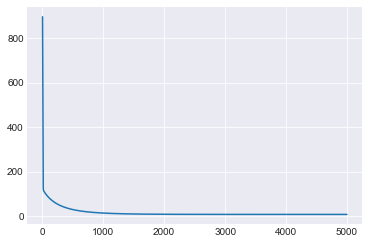

In [20]:
x = np.linspace(1,step,step)
plt.plot(x,cost)



Alternative Solution:
* Globalized Newtown-CG method as in hIPPYlib

## MCMC

In [24]:
def compute_hessian(fn, vars):
    mat = []
    for v2 in vars:
        for i in range(np.shape(vars)[0]):
            jac =[]
            with tf.GradientTape() as t2:
                for v1 in vars:
                    with tf.GradientTape() as t:
                        f = fn(vars)
                        jac.append(t.gradient(f,v1))
                hess = t2.gradient(jac[i],v2)
                if type(hess) == type(None):
                    mat.append(0)
                else:mat.append(hess.numpy())
    return np.reshape(mat,[np.shape(vars)[0],np.shape(vars)[0]])

# def f(vars):
#     return tf.pow(vars[0], cons(2)) + cons(2) * vars[0] * vars[1] + cons(3) * tf.pow(vars[1], cons(2)) + cons(4) * vars[0] + cons(5) * vars[1] + cons(6)
# print(compute_hessian(f,[x,y]))

def gravity(vars):
    G=6.67e-11
    return ((4/3)*np.pi * (vars[2]**3) * vars[1]* G 
       * vars[0]/(x**2 + vars[0]**2)**(3/2)) * 1e5 

mu = MAP

sphere_center = tf.Variable(mu[0])
density_difference = tf.Variable(mu[1])
sphere_radius = tf.Variable(mu[2])

hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])


In [25]:
hess

array([[ 0.00108262, -0.00032089, -0.00474383],
       [-0.00032089,  0.        ,  0.00279868],
       [-0.00474384,  0.00279868,  0.02758266]])

### Forward model in TensorFlow

* Calculate Hessian
* Variable defined in Edward multivariate Normal object

In [252]:
@tf.function
def grav_analytical_tf(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
           * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    
    return gravity

grav = grav_analytical_tf(x_obs, MAP, cov)

print(grav)

tf.Tensor(
[0.07470484 0.09709749 0.12358467 0.15089144 0.1725146  0.18089522
 0.1725146  0.15089144 0.12358467 0.09709749 0.07470484], shape=(11,), dtype=float32)


#### Compute the Hessian and Covariance of the Posterior at MAP

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [253]:
Matrix_tem = tf.add(hess, tf.linalg.inv(cov))

C_post = tf.linalg.inv(Matrix_tem)

In [254]:

print('hessian matrix at MAP: \n', hess)
print('Covariance of the Prior: \n',cov)
print('Covariance of the Posterior: \n',C_post)

hessian matrix at MAP: 
 [[ 0.00108262 -0.00032089 -0.00474383]
 [-0.00032089  0.          0.00279868]
 [-0.00474384  0.00279868  0.02758266]]
Covariance of the Prior: 
 tf.Tensor(
[[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]], shape=(3, 3), dtype=float32)
Covariance of the Posterior: 
 tf.Tensor(
[[ 95.38589     -0.3153458   12.063474  ]
 [ -0.31534898 102.1295      -7.6451163 ]
 [ 12.063485    -7.645117    28.70003   ]], shape=(3, 3), dtype=float32)


#### define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}

\begin{equation}
a\left(m_{\text {current }}, m_{\text {proposed }}\right) :=\min \left\{1, \exp \left(\Phi\left(m_{\text {current }}, \mathbf{d}_{\text {obs }}\right)-\Phi\left(\mathrm{m}_{\text {proposed }}, \mathbf{d}_{\text {obs }}\right)\right)\right\}
\end{equation}

### generalized-preconditioned Crank-Nicolson proposal (gpCN)

gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

In [255]:
def acceptance_gpCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_current = tf.identity(phi_current, name="phi_current")
    
    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_proposed = tf.identity(phi_proposed, name="phi_proposed")

    t2_current = matrixcompute(m_current,mu_prior,cov)
    t3_current = matrixcompute(m_current,MAP,C_post)

    t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
    t3_proposed = matrixcompute(m_proposed,MAP,C_post)

    delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
    delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( delta_current,delta_proposed)
    else_expression = tf.greater(accept_ratio, sample,name = 'shit')
    
    condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())
    

    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        

#### Proposal

\begin{equation}
v^{(k)}=m_{\nu}+\sqrt{1-\beta^{2}}\left(m^{(k)}-m_{\nu}\right)+\beta \xi^{(k)}, \quad \xi^{(k)} \sim \mathcal{N}\left(0, \mathcal{C}_{\nu}\right)
\end{equation}

In [256]:
from IPython.display import clear_output
# define leaning rate
beta = 0.3

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed
    

    

### Chain

In [263]:
def run_chain():
    burn_in = 1000
    steps = 10000
    k = 0
    accepted = []
    rejected = []

    m_current = mu  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        

        if acceptance_gpCN(m_current,m_proposed).numpy():
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed)
        else:
            m_current = m_current
            rejected.append(m_proposed)
    
    return accepted,rejected
    
accepted,rejected = run_chain()

In [264]:
np.shape(accepted)[0]

5062

In [265]:
def plot_trace(accepted):
            
    sphere_center_accepted = []
    density_difference_accepted = []
    sphere_radius_accepted = []
    for i in range(np.shape(accepted)[0]):
        
        sphere_center_accepted.append(accepted[i][0])
        density_difference_accepted.append(accepted[i][1])
        sphere_radius_accepted.append(accepted[i][2])
        
        
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
    fig.set_size_inches(17, 4)
    
    axes[0].hist(sphere_center_accepted,40,density=True)
    axes[1].hist(density_difference_accepted,40,density=True)
    axes[2].hist(sphere_radius_accepted,40,density=True)


    ## print prior
    for i in range(3):

        axes[i].plot(xvals[i], norm_list[i],label="prior")
        axes[i].title.set_text(name_list[i])
        axes[i].axvline(truevalue_list[i], label="true value", color='k', 
                linestyle='--', linewidth=2)
        axes[i].legend();


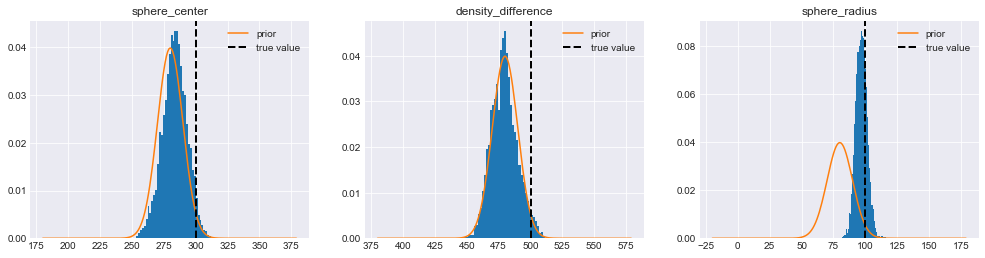

In [266]:
plot_trace(accepted)

In [267]:
import corner 

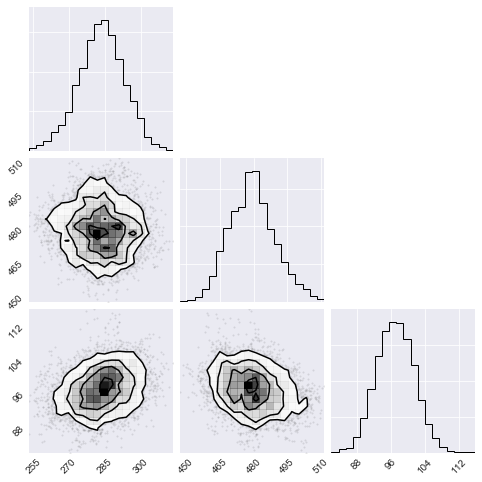

In [268]:
figure = corner.corner(accepted)